In [1]:
%matplotlib inline
from matplotlib.colors import LogNorm, SymLogNorm
import numpy as np
import glob
import scipy
from astropy.io import fits
import matplotlib.pyplot as plt

from ctisim import ITL_AMP_GEOM
from ctisim.fitting import FullSimulatedModel, OverscanFitting

In [16]:
infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'

hdulist = fits.open(infile)
max_signal = 160000.
read_noise = 7.2

amp = 7
start = 1
stop = 15

## Model params
ctiexp = np.log10(1.1E-6)
drift_scale = 0.0002
decay_time = 2.5
trapsize1 = 3.8
scaling = 0.08
trapsize2 = 38.0
f0 = 17700.
k = 0.001
emission_time = 0.4
params0 = (ctiexp, drift_scale, decay_time, trapsize1, scaling, trapsize2, f0, k, emission_time)

## Constraints
constraints = [(np.log10(8.E-7), np.log10(3.E-6)),
               (0.00015, 0.00025),
               (2.3, 2.6),
               (0.0, 5.0),
               (0.05, 0.1),
               (35.0, 45.0),
               (16000., 18000.),
               (0.0007, 0.0013),
               (0.35, 0.5)]

<class 'numpy.float32'>


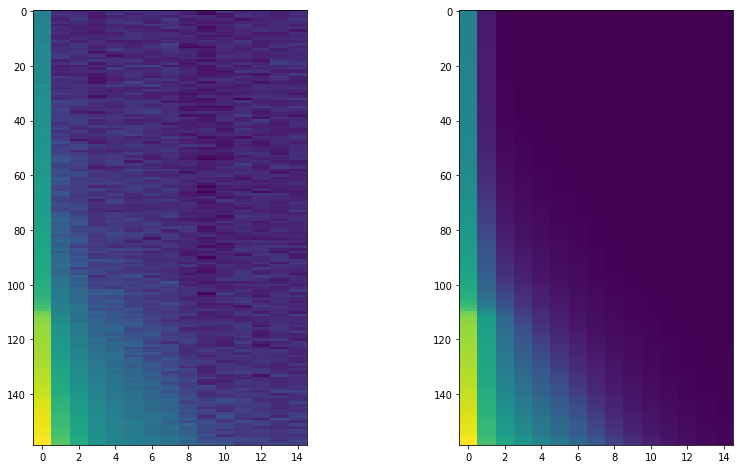

In [3]:
## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Model
fitting_model = FullSimulatedModel(params0, ITL_AMP_GEOM)
model = fitting_model.results(signals, start=start, stop=stop)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
im0 = axes[0].imshow(data, norm=SymLogNorm(1.0), interpolation='none')
im1 = axes[1].imshow(model, norm=SymLogNorm(1.0), interpolation='none')
axes[0].set_aspect(0.15)
axes[1].set_aspect(0.15)

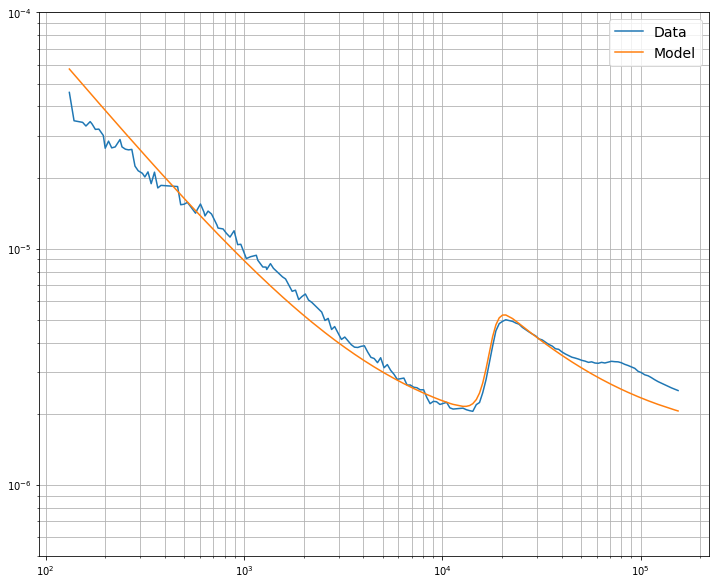

In [4]:
cti_data = np.sum(data[:, :2], axis=1)/(512*signals)
cti_model = np.sum(model[:, :2], axis=1)/(512*signals)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(signals, cti_data, label='Data')
ax.plot(signals, cti_model, label='Model')
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylim(5E-7, 1E-4)
ax.set_xscale('log')
ax.grid(which='both', axis='both')

In [13]:
fit_task = OverscanFitting(params0, constraints, FullSimulatedModel, start=start, stop=stop)

error = 7.2/np.sqrt(2000.)
fit_task.rms_error(params0, signals, data, read_noise/np.sqrt(2000.), ITL_AMP_GEOM)

2.8612484294548786

In [17]:
x = scipy.optimize.minimize(fit_task.rms_error,
                            params0,
                            args=(signals, data, read_noise/np.sqrt(2000.), ITL_AMP_GEOM),
                            bounds=constraints, method='SLSQP')

In [18]:
print(x)

     fun: 0.8711045372445387
     jac: array([-2.49758363e-04,  4.12825108e-01,  5.69450110e-03,  4.30122018e-05,
       -1.09448321e-01,  1.22809559e-02, -6.58407807e-05, -8.16234201e-03,
        1.07172877e-03])
 message: 'Optimization terminated successfully.'
    nfev: 275
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([-5.79218952e+00,  2.46516553e-04,  2.30000000e+00,  2.72574811e+00,
        9.99999998e-02,  3.50000000e+01,  1.77000125e+04,  1.10319904e-03,
        3.61434550e-01])
